In [59]:
import pandas as pd
from pandas import option_context
import numpy as np
import requests
import seaborn as sns
import datetime
import cliffsDelta as cd
import matplotlib.pyplot as plt

from tqdm import tqdm
from statsmodels.stats.inter_rater import fleiss_kappa,aggregate_raters
from scipy.stats import mannwhitneyu,shapiro,ttest_ind

In [118]:
QUERY_ROOT = "https://api.github.com"
TOKEN = '' # write your GitHub API key here
HEADERS={'Authorization':'token '+TOKEN}
CSVPATH = "homebrew_homebrew-core_1/homebrew_homebrew-core_1.csv"

## Section 3

### Question 1

#### Write an automated Python script to identify the GitHub Apps in the list of accounts, by calling the GitHub Users API and extracting the required information to make this decision. 

#### More information: You can search for the "type" key in the obtianed JSON result, If it is "Bot", then it is an app, if it is "User", then it is an account.

In [18]:
# 1. Read the given .csv file into a pandas DataFrame (df).
# 2. Make sure there are 2 columns, one column name is "contributor" that has the name of the contributor, 
#    and another column name is "bothunter" that you will use later on in this assignment.
# 3. Display the DataFrame.
df = pd.read_csv(CSVPATH)

if 'contributor' not in df.columns or 'bothunter' not in df.columns:
    print("Error: The CSV file must contain 'contributor' and 'bothunter' columns.")
    exit(1)

print("DataFrame:")
print(df)

DataFrame:
                contributor bothunter
0            flyio-buildbot       Bot
1         blockstack-devops       Bot
2                SMillerDev     Human
3                    petere     Human
4                 bfontaine     Human
5                   zuisong     Human
6          asyncapi-bot-eve       Bot
7            EricFromCanada     Human
8                   Moulick     Human
9               BrewTestBot       Bot
10                 carlocab     Human
11                  ddollar     Human
12                  seratch     Human
13                   sferik     Human
14                  samford     Human
15            jesseduffield     Human
16                    claui     Human
17               jeremylong     Human
18                  tchajed     Human
19          FnControlOption     Human
20         flyio-flyctl-bot       Bot
21                     avsm     Human
22              denysdovhan     Human
23                 derrabus     Human
24  github-merge-queue[bot]       Bot
2

In [19]:
# 1. Store the names of the contributors in a list using the code snippet: 'df.contributor.to_list()'
# 2. print the list

contributors_list = df.contributor.to_list()

print("List of Contributors:")
print(contributors_list)

List of Contributors:
['flyio-buildbot', 'blockstack-devops', 'SMillerDev', 'petere', 'bfontaine', 'zuisong', 'asyncapi-bot-eve', 'EricFromCanada', 'Moulick', 'BrewTestBot', 'carlocab', 'ddollar', 'seratch', 'sferik', 'samford', 'jesseduffield', 'claui', 'jeremylong', 'tchajed', 'FnControlOption', 'flyio-flyctl-bot', 'avsm', 'denysdovhan', 'derrabus', 'github-merge-queue[bot]', 'jidicula', 'bevanjkay', 'branchvincent', 'nevack', 'mkhl', 'wing328', 'stgraber', 'soloio-bot', 'matchai', 'kevinAlbs', 'curquiza', 'dandavison', 'pulumi-bot', 'epistrephein', 'github-actions[bot]']


In [20]:
# 1. Using a for loop, iterate over each contributor in the list and query the GitHub Users API.
#    You can use "query = f'{QUERY_ROOT}/users/{contributor}'", where QUERY_ROOT is defined at the beginning of this notebook 
#    above and 'contributor' is each individul contributor from the list
# 2. Get the response using 'response = requests.get(query, headers=HEADERS)'.
# 3. convert the response to JSON using 'json_response = response.json()'.
# 4. Iterate over this JSON response and get the value of the 'type' key. If it is "Bot" then the contributor is an App, 
#    if "User" then the contributor is an account. You should boolean values to indicate if the contributor is an App (True) or User/Organisation (False)
# 5. Save these results in list of dictionary of the form [{'contributor': <contributor name>, 'app': <boolean value>}, {...}, {...}, {...}].
#    Lets call this list as "app_list_dict"
# 6. Finally convert this list of dictionary to DataFrame by writing 'pd.DataFrame.from_dict(app_dict)'
# 7. Display the DataFrame. This should have two columns - contributor and app

app_dict = []

for contributor in df['contributor']:
    query = f"{QUERY_ROOT}/users/{contributor}"
    response = requests.get(query, headers=HEADERS)
    json_response = response.json()
    
    if "type" in json_response:
        is_app = True if json_response["type"] == "Bot" else False
    else:
        is_app = False
    
    app_dict.append({'contributor': contributor, 'app': is_app})

app_df = pd.DataFrame.from_dict(app_dict)

print("DataFrame:")
print(app_df)


DataFrame:
                contributor    app
0            flyio-buildbot  False
1         blockstack-devops  False
2                SMillerDev  False
3                    petere  False
4                 bfontaine  False
5                   zuisong  False
6          asyncapi-bot-eve  False
7            EricFromCanada  False
8                   Moulick  False
9               BrewTestBot  False
10                 carlocab  False
11                  ddollar  False
12                  seratch  False
13                   sferik  False
14                  samford  False
15            jesseduffield  False
16                    claui  False
17               jeremylong  False
18                  tchajed  False
19          FnControlOption  False
20         flyio-flyctl-bot  False
21                     avsm  False
22              denysdovhan  False
23                 derrabus  False
24  github-merge-queue[bot]   True
25                 jidicula  False
26                bevanjkay  False
27       

### Question 2

#### Add an app column in the CSV file to store this information. You can write True if it is an app and False if it is not.


In [21]:
# Merge the app DataFrame to df by writing 'pd.merge(df, <app df>, on='contributor'). This is similar to SQL join on primary key 'contributor'.
# The resultant df should have 3 columns - contributor, bothunter and app.

merged_df = pd.merge(df, app_df, on='contributor')

merged_df.to_csv(CSVPATH, index=False)

### Question 3

#### Report on the total number of GitHub Apps, and User accounts present in the list of accounts of your dataset.

In [22]:
num_apps = merged_df['app'].sum()
num_users = merged_df.shape[0] - num_apps

print("Report on GitHub Apps and User accounts:")
print("Total number of GitHub Apps:", num_apps)
print("Total number of User accounts:", num_users)

Report on GitHub Apps and User accounts:
Total number of GitHub Apps: 2
Total number of User accounts: 38


## Section 4

### Question 1

#### Write an automated script to report on the prediction of the GitHub accounts in your dataset, using BoDeGHa and RABBIT bot identification tools. For each tool, your script should add an extra column to the CSV ﬁle of your dataset, reporting the prediction (bot, human, unknown) of the considered tool on the considered account.

#### More information:
You can write an automated script to execute BoDeGHa and RABBIT, and save the results in a DataFrame. For BoDeGHa, you can ask the tool to give the output in CSV format, save it as a csv file and read it in a DataFrame. For RABBIT, you can use its internal argument to store the results in a .csv file and read it in a DataFrame. Remember to read their Documentation (Readme.md) for their input arguments and example outputs before using these tools.  
Similar to what you did in Section 2 - Question 1 and 2, add an additional column named 'bodegha' to store the predictions 
given by BoDeGHa and add another column called 'rabbit' to store the preditions given by RABBIT. 

In [23]:
# Read the .csv file that has the predicitons given by BoDeGHa.

bodegha_predictions_df = pd.read_csv('homebrew_homebrew-core_1/bodegha_predictions.csv')
print(bodegha_predictions_df)

                account prediction
0              curquiza        Bot
1            jeremylong        Bot
2            pulumi-bot        Bot
3           BrewTestBot      Human
4        EricFromCanada      Human
5               Moulick      Human
6            SMillerDev      Human
7             bevanjkay      Human
8         branchvincent      Human
9              carlocab      Human
10             derrabus      Human
11              samford      Human
12              zuisong      Human
13  github-actions[bot]        Bot


In [24]:
# merge it to df - Now your df should have the following four columns - contributor, bothunter, app, bodegha

df = pd.merge(merged_df, bodegha_predictions_df, left_on='contributor', right_on='account', how='left')
df.drop('account', axis=1, inplace=True)
df.rename(columns={'prediction': 'bodegha'}, inplace=True)
df['bodegha'] = df['bodegha'].fillna('Unknown')

print(df)

                contributor bothunter    app  bodegha
0            flyio-buildbot       Bot  False  Unknown
1         blockstack-devops       Bot  False  Unknown
2                SMillerDev     Human  False    Human
3                    petere     Human  False  Unknown
4                 bfontaine     Human  False  Unknown
5                   zuisong     Human  False    Human
6          asyncapi-bot-eve       Bot  False  Unknown
7            EricFromCanada     Human  False    Human
8                   Moulick     Human  False    Human
9               BrewTestBot       Bot  False    Human
10                 carlocab     Human  False    Human
11                  ddollar     Human  False  Unknown
12                  seratch     Human  False  Unknown
13                   sferik     Human  False  Unknown
14                  samford     Human  False    Human
15            jesseduffield     Human  False  Unknown
16                    claui     Human  False  Unknown
17               jeremylong 

In [25]:
# Read the predictions given by RABBIT from the corresponding .csv file 

rabbit_predictions_df = pd.read_csv('homebrew_homebrew-core_1/rabbit_predictions.csv')
print(rabbit_predictions_df)

    Unnamed: 0                  account prediction  confidence
0            0      flyio-buildbot\tBot    invalid         NaN
1            1   blockstack-devops\tBot    invalid         NaN
2            2        SMillerDev\tHuman    invalid         NaN
3            3            petere\tHuman    invalid         NaN
4            4         bfontaine\tHuman    invalid         NaN
5            5           zuisong\tHuman    invalid         NaN
6            6    asyncapi-bot-eve\tBot    invalid         NaN
7            7    EricFromCanada\tHuman    invalid         NaN
8            8           Moulick\tHuman    invalid         NaN
9            9         BrewTestBot\tBot    invalid         NaN
10          10          carlocab\tHuman    invalid         NaN
11          11           ddollar\tHuman    invalid         NaN
12          12           seratch\tHuman    invalid         NaN
13          13            sferik\tHuman    invalid         NaN
14          14           samford\tHuman    invalid     

In [26]:
# merge it to df - Now your df should have the following five columns - contributor, bothunter, app, bodegha, rabbit
rabbit_predictions_df.drop(rabbit_predictions_df.columns[0],axis=1, inplace=True)
df = pd.merge(df, rabbit_predictions_df, left_on='contributor', right_on='account', how='left')

df.drop('account', axis=1, inplace=True)
df.drop('confidence', axis=1, inplace=True)
df.rename(columns={'prediction': 'rabbit'}, inplace=True)
df['rabbit'] = df['rabbit'].fillna('Unknown')

print(df)

                contributor bothunter    app  bodegha   rabbit
0            flyio-buildbot       Bot  False  Unknown  Unknown
1         blockstack-devops       Bot  False  Unknown  Unknown
2                SMillerDev     Human  False    Human  Unknown
3                    petere     Human  False  Unknown  Unknown
4                 bfontaine     Human  False  Unknown  Unknown
5                   zuisong     Human  False    Human  Unknown
6          asyncapi-bot-eve       Bot  False  Unknown  Unknown
7            EricFromCanada     Human  False    Human  Unknown
8                   Moulick     Human  False    Human  Unknown
9               BrewTestBot       Bot  False    Human  Unknown
10                 carlocab     Human  False    Human  Unknown
11                  ddollar     Human  False  Unknown  Unknown
12                  seratch     Human  False  Unknown  Unknown
13                   sferik     Human  False  Unknown  Unknown
14                  samford     Human  False    Human  

In [27]:
# Replace the prediction result given by rabbit from 'bot' to 'Bot', 'app' to 'Bot', 'human' to 'Human', 'unknown' to 'Unknown' to maintain consistency

df['rabbit'] = df['rabbit'].replace({'bot': 'Bot', 'app': 'Bot', 'human': 'Human'})
print(df)

                contributor bothunter    app  bodegha   rabbit
0            flyio-buildbot       Bot  False  Unknown  Unknown
1         blockstack-devops       Bot  False  Unknown  Unknown
2                SMillerDev     Human  False    Human  Unknown
3                    petere     Human  False  Unknown  Unknown
4                 bfontaine     Human  False  Unknown  Unknown
5                   zuisong     Human  False    Human  Unknown
6          asyncapi-bot-eve       Bot  False  Unknown  Unknown
7            EricFromCanada     Human  False    Human  Unknown
8                   Moulick     Human  False    Human  Unknown
9               BrewTestBot       Bot  False    Human  Unknown
10                 carlocab     Human  False    Human  Unknown
11                  ddollar     Human  False  Unknown  Unknown
12                  seratch     Human  False  Unknown  Unknown
13                   sferik     Human  False  Unknown  Unknown
14                  samford     Human  False    Human  

### Question 2

#### Add an extra column to the CSV ﬁle called 'manual' that has the label determined by you. For each account, of your own opinion on its nature (bot, human or unknown only in case of doubt) on the basis of a manual veriﬁcation of the contributor’s activities in the repository through the GitHub UI and through the GitHub Events API https://api.github.com/users/username/events, and taking into account the prediction made by the bot identification tools.

#### More information:
For each contributor, look at their activities in GitHub UI, look at their latest events using GitHub Events API - https://api.github.com/users/<contributor\>/events, to make a decision on their type. 

In addition, you should also write a very small reason why do you think they are bot or human (e.g., same activity at regular interval so Bot, files committed and code modified looks like Human, comments look like Human, comment look like Bot, test report looks automated so Bot, and so on....). This might be useful to answer the next question as well.

In [28]:
# Write your manual decision here
# example : 
# manual_list_dict = [{'contributor': 'tommens', 'manual': 'human'}, {....}, {....}, {....}]
# pd.DataFrame.from_dict(manual_list_dict)

# YOUR CODE BELOW


In [29]:
# merge it with df of predictions. Now your df should have the following six columns
# contributor, bothunter, app, bodegha, rabbit, manual

# YOUR CODE BELOW


### Question 3

#### Study and report the purpose of these identified bots and humans in the repository assigned to you. 

For example, the purpose can be based on but not limited to - 

the type of activities that they are performing (releasing a version on every Sunday, updating the documentation), type of comments they are posting (reviewing code, test summary report), when are they triggered (when a new PR is created, when someone in the project ask the bot to merge the code) and so on. \textbf{Note:} The purpose can be other than what is provided in examples above. 


### Question 4

#### Create a column named 'type' to the CSV ﬁle and write your ﬁnal decision on the type of contributor. The ﬁnal decision on their type is the prediciton that majority of the raters predicted (you can ignore the 'Unknown'), in the case of contradiction, you can finalise it as Human.
#### Case 1: If two raters has mentioned a contributor as Bot and others mentioned it as 'Unknown', then the type of the account is Bot.  
#### Case 2: If 3 raters give 'Unknown' to a contributor then the prediction given by the fourth rater is final.
#### Case 3: If 2 raters give the prediciton as 'Bot' and 2 raters give it as 'Human', then the final decision is 'Human'
#### In this step, GitHub Apps should be marked as App and not as a Bot.

In [30]:
# Make a final decision on the type based on the predictions given by bothunter, bodegha, bothunter and your manual labelling. 
# Now your df should contain seven columns - contributor, bothunter, app, bodegha, rabbit, manual and type

df['bot_count'] = df[['bothunter', 'bodegha', 'rabbit']].apply(lambda row: row.value_counts().get('Bot', 0), axis=1)
df['human_count'] = df[['bothunter', 'bodegha', 'rabbit']].apply(lambda row: row.value_counts().get('Human', 0), axis=1)

def final_decision(row):
    if row['bot_count'] > row['human_count']:
        return 'Bot'
    else:
        return 'Human'

df['type'] = df.apply(final_decision, axis=1)
df.loc[df['app'], 'type'] = 'App'
df.drop(['bot_count', 'human_count'], axis=1, inplace=True)
print(df)

                contributor bothunter    app  bodegha   rabbit   type
0            flyio-buildbot       Bot  False  Unknown  Unknown    Bot
1         blockstack-devops       Bot  False  Unknown  Unknown    Bot
2                SMillerDev     Human  False    Human  Unknown  Human
3                    petere     Human  False  Unknown  Unknown  Human
4                 bfontaine     Human  False  Unknown  Unknown  Human
5                   zuisong     Human  False    Human  Unknown  Human
6          asyncapi-bot-eve       Bot  False  Unknown  Unknown    Bot
7            EricFromCanada     Human  False    Human  Unknown  Human
8                   Moulick     Human  False    Human  Unknown  Human
9               BrewTestBot       Bot  False    Human  Unknown  Human
10                 carlocab     Human  False    Human  Unknown  Human
11                  ddollar     Human  False  Unknown  Unknown  Human
12                  seratch     Human  False  Unknown  Unknown  Human
13                  

### Question 5 (a)

#### Compute and report the Fleiss Kappa interrater agreement score between the labels computed by all bot identiﬁcation tools.

##### For example:

converted_df = aggregate_raters(np.array(df[['rater1','rater2']]))  
kappa = fleiss_kappa(converted_df[0])  
print('kappa')  

#### a. between bothunter and rabbit

In [31]:
converted_df = aggregate_raters(np.array(df[['bothunter','rabbit']]))
kappa = fleiss_kappa(converted_df[0])
print('kappa : ', kappa)

kappa :  0.1946308724832215


#### b. between bothunter and bodegha

In [32]:
converted_df = aggregate_raters(np.array(df[['bothunter','bodegha']]))
kappa = fleiss_kappa(converted_df[0])
print('kappa : ', kappa)

kappa :  -0.19772844605059373


#### c. between bodegha and rabbit

In [33]:
converted_df = aggregate_raters(np.array(df[['bodegha','rabbit']]))
kappa = fleiss_kappa(converted_df[0])
print('kappa : ', kappa)

kappa :  -0.0946907498631638


#### d. between bothunter, bodegha and rabbit

In [34]:
converted_df = aggregate_raters(np.array(df[['bothunter','bodegha','rabbit']]))
kappa = fleiss_kappa(converted_df[0])
print('kappa : ', kappa)

kappa :  0.015496809480401148


### Question 5 (b)
#### Report on
#### a. What is you interpretation from the kappa values (use the table provided in the description document)? what do you understand?

In [35]:
#The kappa values obtained range from "no agreement" to "slight agreement".
#It tells us that the bot identiﬁcation tools interpreted data quite differently.
#It also means that there is a maximum of one good bot identification tool (there could be none) because
#If there is more than one, they should agree more about predictions.

#### b. Based on your previous analysis, which bot identification tool would you use, if you want to predict if a contributor is a human or bot? Motivate your answer

In [36]:
#When compared in pairs, BoDeGHa appears to be less trustworthy because it clearly disagrees with the results of the other tools.
#Among BotHunter and Rabbit, Rabbit shows the highest level of agreement with BoDeGHa.
#Therefore, I would choose Rabbit, although no tool seems to significantly outperform the others.

## Section 5

#### Query the GitHub Events API to get maximum possible events for each contributor (maximum is 300 events).  
#### You can use the following query: '{QUERY_ROOT}/users/{contributor}/events?per_page=100&page={page}' where page = 1 or 2 or 3  
#### As you did in earlier task, make a request to GitHub Events API with the required headers, convert the response to JSON, extract the following fields and store in a DataFrame:
Event id - json_response['event_id']  
Name of the contributor - json_response['actor']['login']  
Name of the repository - json_response['repository']['name']  
Type of event - json_response['type']  
Time of event - json_response['created_at']

#### Hint: Query the GitHubEvents API for all contributors. Append the obtained JSON result to a list of JSONs. Process one dictionary after other to get your required fields and store them in another list of dictionaries. Finally convert this dictionaty to DataFrame. OR You can directly convert the list of JSONs to DataFrame using pd.json_normalize() and select the required columns alone.

#### The resultant dataframe should have all the recent events performed by all the contributors and the following columns should be present in them - event_id, contributor, repo_name, event_type, created_at.


In [51]:
df_section5 = pd.read_csv(CSVPATH)

def fetch_contributor_events(contributor, page):
    url = f'https://api.github.com/users/{contributor}/events?per_page=100&page={page}'
    response = requests.get(url, headers=HEADERS)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch events for {contributor} on page {page}. Status code: {response.status_code}")
        return []

all_events = []
for contributor in df_section5['contributor'].unique():
    for page in range(1, 4):  # Pages are limited to 1, 2, and 3
        contributor_events = fetch_contributor_events(contributor, page)
        all_events.extend(contributor_events)

processed_events = []
for event in all_events:
    processed_event = {
        'event_id': event['id'],
        'contributor': event['actor']['login'],
        'repo_name': event['repo']['name'],
        'event_type': event['type'],
        'created_at': event['created_at']
    }
    processed_events.append(processed_event)

df_section5 = pd.DataFrame(processed_events)

df_section5

,event_id,contributor,repo_name,event_type,created_at
0,36997111539,flyio-buildbot,superfly/flyctl,CreateEvent,2024-03-29T11:50:40Z
1,36984010934,flyio-buildbot,superfly/flyctl,CreateEvent,2024-03-28T23:06:37Z
2,36979299396,flyio-buildbot,superfly/flyctl,CreateEvent,2024-03-28T19:29:53Z
3,36967471804,flyio-buildbot,superfly/flyctl,CreateEvent,2024-03-28T13:19:08Z
4,36952078770,flyio-buildbot,superfly/flyctl,CreateEvent,2024-03-28T02:35:49Z
...,...,...,...,...,...
8754,37003670693,github-actions[bot],starterstack/starterstack,IssueCommentEvent,2024-03-29T16:46:12Z
8755,37003670627,github-actions[bot],aksamlan/lava,PushEvent,2024-03-29T16:46:12Z
8756,37003670664,github-actions[bot],pemkotbekasi/photo_gallery,PushEvent,2024-03-29T16:46:12Z
8757,37003670454,github-actions[bot],starterstack/starterstack,CreateEvent,2024-03-29T16:46:12Z


### Question 1
#### Group each event into the following four categories

Issues: IssueCommentEvent, IssuesEvent  
Pull Requests: PullRequestEvent, PullRequestReviewCommentEvent  
Commits: CommitCommentEvent, PushEvent  
Repository: CreateEvent, DeleteEvent, ForkEvent, GollumEvent, MemberEvent, PublicEvent, ReleaseEvent, SponsorshipEvent, WatchEvent  

#### Hint:
1. Add a column called event_group that mentions which event group does that event belong to. Each event (row) should correspond to an event group.  
2. Then perform groupby on ['contributor','event_group'],  
3. use .agg (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) to count the number of events performed by each contributor in each group,  
4. use pivot with the required arguments (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html). An example is given [here](#pivot_example) in question 2(b), and  
5. finally merge it with your 'type' field from the DataFrame you got in Section4

The final DataFrame should be looking like the following  
![](event_group.png)

In [52]:
# In the resultant DataFrame - each row should corespond to a contributor, and the columns should have all the event groups  
# and the type of the contributor (that you decided in the previous DataFrame) and the values should be the number 
# of events of that event event group the contriubutor has performed.

issue_group = ['IssueCommentEvent', 'IssuesEvent']
pr_group = ['PullRequestEvent', 'PullRequestReviewCommentEvent']
commit_group = ['CommitCommentEvent', 'PushEvent']
repo_group = ['CreateEvent', 'DeleteEvent', 'ForkEvent', 'GollumEvent', 'MemberEvent', 'PublicEvent', 'ReleaseEvent', 'SponsorshipEvent', 'WatchEvent']

In [53]:
def categorize_event(event_type):
    if event_type in issue_group:
        return 'Issues'
    elif event_type in pr_group:
        return 'Pull Requests'
    elif event_type in commit_group:
        return 'Commits'
    elif event_type in repo_group:
        return 'Repository'

df_section5['event_group'] = df_section5['event_type'].apply(categorize_event)

grouped_df = df_section5.groupby(['contributor', 'event_group']).agg(event_count=('event_type', 'size')).reset_index()

pivot_df = grouped_df.pivot(index='contributor', columns='event_group', values='event_count').fillna(0).reset_index()

final_df = pivot_df.merge(df[['contributor', 'type']], on='contributor').drop_duplicates()

print(final_df)

                contributor  Commits  Issues  Pull Requests  Repository   type
0               BrewTestBot     66.0     0.0           93.0        91.0  Human
1            EricFromCanada     18.0    12.0           21.0        33.0  Human
2           FnControlOption     18.0     5.0            4.0         6.0  Human
3                   Moulick    100.0    63.0           22.0       105.0  Human
4                SMillerDev     55.0    48.0           65.0        15.0  Human
5          asyncapi-bot-eve    157.0     0.0            0.0        11.0    Bot
6                      avsm     20.0    33.0           18.0         7.0  Human
7                 bevanjkay     66.0    16.0           80.0        22.0  Human
8                 bfontaine     90.0    37.0            3.0        61.0  Human
9         blockstack-devops     34.0   101.0            6.0        69.0    Bot
10            branchvincent     28.0     9.0           62.0        95.0  Human
11                 carlocab     31.0    35.0        

In [54]:
# YOUR CODE BELOW


### Question 2 (a)

#### Compute the median number of events per event group for Bot+Apps and Humans and write in DataFrame.

Row should correspond to type (Bot_App and Human), Column should have Event group name and the values should be the median value of Bot_App or Human for that particular event group. An example is given below

In [44]:
# For example:
medians = [{'event_group': 'event_group1', 'median': 'val1', 'type': 'Bot_app'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'type': 'Bot_app'},
           {'event_group': 'event_group2', 'median': 'val4', 'type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'type': 'Bot_app'},
           {'event_group': 'event_group3', 'median': 'val6', 'type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'type': 'Bot_app'},
           {'event_group': 'event_group5', 'median': 'val8', 'type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,type
0,event_group1,val1,Bot_app
1,event_group1,val2,Human
2,event_group2,val3,Bot_app
3,event_group2,val4,Human
4,event_group3,val5,Bot_app
5,event_group3,val6,Human
6,event_group4,val7,Bot_app
7,event_group5,val8,Human


In [115]:
final_df['type'] = final_df['type'].replace({'Bot': 'Bot_app', 'App': 'Bot_app'})

results = []

for event_group in ['Commits', 'Issues', 'Pull Requests', 'Repository']:
    medians_human = final_df[final_df['type'] == 'Human'][event_group].median()
    medians_bot_app = final_df[final_df['type'] == 'Bot_app'][event_group].median()
    
    results.append({'event_group': event_group, 'median': medians_human, 'type': 'Human'})
    
    results.append({'event_group': event_group, 'median': medians_bot_app, 'type': 'Bot_app'})

median_df = pd.DataFrame(results)

print(median_df)

     event_group  median     type
0        Commits    54.0    Human
1        Commits    61.5  Bot_app
2         Issues    23.0    Human
3         Issues     2.0  Bot_app
4  Pull Requests    44.5    Human
5  Pull Requests     4.5  Bot_app
6     Repository    32.0    Human
7     Repository    28.0  Bot_app


### Question 2 (b)

Plot a heatmap of the DataFrame using seaborn - 
1. First convert the dataframe to the required format using pivot, example is given below
2. plot using seaborn - sns.heatmap(df_medians, annot=True, vmin=0, vmax=300, cmap="crest"). More details: https://seaborn.pydata.org/generated/seaborn.heatmap.html)

#### pd.pivot example:
<a id='pivot_example'></a>

In [23]:
# Main DataFrame
medians = [{'event_group': 'event_group1', 'median': 'val1', 'type': 'Bot_app'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'type': 'Bot_app'},
           {'event_group': 'event_group2', 'median': 'val4', 'type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'type': 'Bot_app'},
           {'event_group': 'event_group3', 'median': 'val6', 'type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'type': 'Bot_app'},
           {'event_group': 'event_group5', 'median': 'val8', 'type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,type
0,event_group1,val1,Bot_app
1,event_group1,val2,Human
2,event_group2,val3,Bot_app
3,event_group2,val4,Human
4,event_group3,val5,Bot_app
5,event_group3,val6,Human
6,event_group4,val7,Bot_app
7,event_group5,val8,Human


In [99]:
# pivot the main DataFrame
plot_df = median_df.pivot(index='type', columns='event_group', values='median').reset_index().rename_axis(None,axis=1)

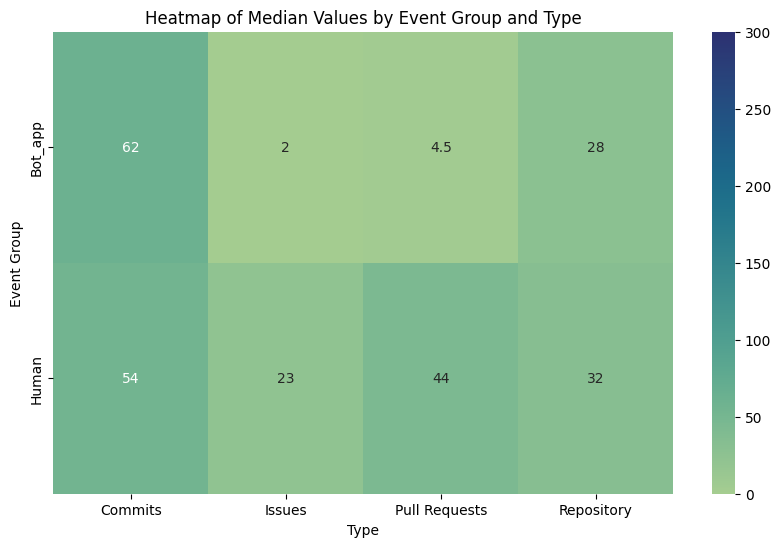

In [100]:
plot_df.set_index('type', inplace=True)

plt.figure(figsize=(10, 6))
sns.heatmap(plot_df, annot=True, vmin=0, vmax=300, cmap="crest")
plt.title('Heatmap of Median Values by Event Group and Type')
plt.xlabel('Type')
plt.ylabel('Event Group')
plt.show()

In [26]:
# YOUR CODE BELOW


#### What is the difference that you observe between Bots+Apps and Humans?

In [104]:
#The humans have generally more events than Bots+Apps.

#### What is the differnce that you observe between Event groups?

In [105]:
#Commits is the dominant event group while Issues are the least common.

#### What is the difference that you observe between Bots+Apps and Humans and Event groups all considering at the same time?

In [106]:
#Humans and Bots/Apps have more or less the same amount of repository and commits (Bots/Apps have actually a bit more commits).
#However, Humans tend to have way more issues and pull requests.

### Question 3

#### Create box plots or boxen plots or violin plots or a combination of these to visualise the distribution of number of events in each event group. 
#### For more information you can visit - https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial  
#### For violin plots - https://seaborn.pydata.org/generated/seaborn.violinplot.html  
#### You should highlight the data points that correspond to bots using a stripplot in seaborn. https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial  
#### Interpret the results of the visualisation.

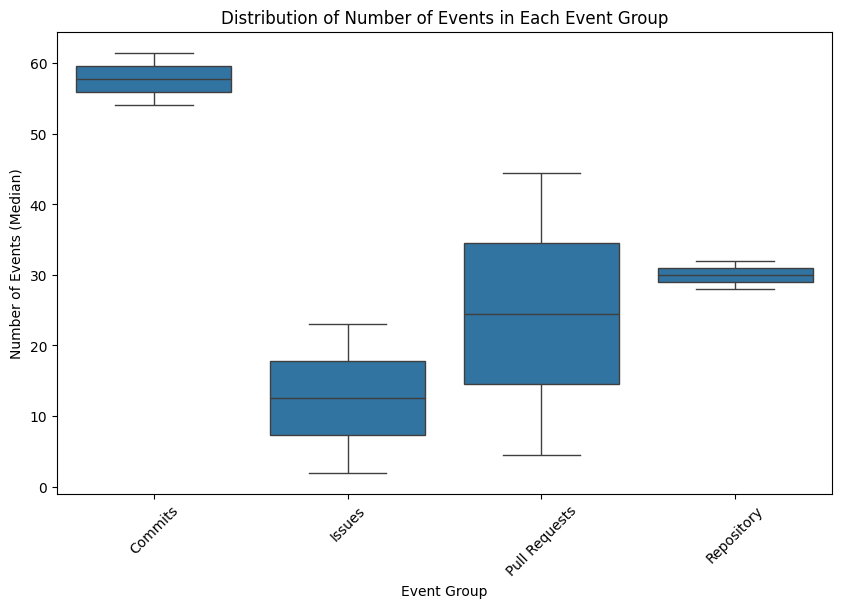

In [110]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='event_group', y='median', data=median_df)
plt.title('Distribution of Number of Events in Each Event Group')
plt.xlabel('Event Group')
plt.ylabel('Number of Events (Median)')
plt.xticks(rotation=45)
plt.show()

In [111]:
#There are relatively few issues compared to other event groups, and the number varies quite significantly between humans and bots/apps.
#The number of pull requests varies significantly between humans and bots/apps.
#There can be as many pull requests as repositories (humans) or as few as for issues (bots/apps).
#The number of repositories is quite large compared to issues but quite small compared to commits.
#The difference in the number of repositories between humans and bots/apps is nearly inexistant.
#There are more or less as many commits for humans than for bots/apps and the commits are by far the more common event type.

In [29]:
# YOUR CODE BELOW - Visualise number of events from commit event group
#

In [30]:
# YOUR CODE BELOW - Visualise number of events from repo event group


### Question 4.1

#### Statistical identify whether number of events in each event group is normally distributed or not.
#### Null hypothesis - $H_0$: Sample comes from the data that has normal distribution.
#### Use Shapiro-Wilk test for this purpose. Use the p-value with a threshold of 0.05 to determine whether $H_0$ can be rejected with statistical significance or not. 

#### Use shapiro from scipy.stats to perform this test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

### Question 4.2
#### Determine if there is any statistical diﬀerence in number of events between the identified event groups. Perform this test on all pairs of event groups. 
#### Null hypothesis - $H_0$: Any two event group come from the same population.
#### If $H_0$ is rejected in Shapiro-Wilk test (at least for one of the two event groups considered for test), use the Mann-Whitney U statistical test for this purpose. If $H_0$ is not rejected in Shapiro-Wilk test, use the independent t-test for this purpose.  
#### In any case, use the p-value with a threshold of 0.01 to determine whether $H_0$ can be rejected with statistical significance. 

#### Use mannwhitneyu from scipy.stats to perform Mann-Whitney U test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) 
#### or 
#### ttest_ind from scipy.stats to perform independent t-test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html.

#### More information:

You can pass the following arguments to mannwhitneyu from scipy.stats - (method='exact', nan_policy='omit'). For ttest_ind you can use - (nan_policy='omit')

### Question 5
#### Each time you reject the null hypothesis $H_0$, quantify the effect size of the diﬀerence between the groups using cliﬀ’s delta ($\delta$). 
#### To calculate cliﬀ’s delta, you can pass the list of values to cliﬀ delta.py file given in the repository. E.g., cliffsDelta.cliffsDelta(list of values). This will return the effect size and its interpretation (negligible, small, medium, large).

In [ ]:
# YOU CODE BELOW

### Qusetion 6

#### Create violinplots to visualise the distributions for the following metrics and answer the questions that follow it. You should highlight the data points corresponding to bots using a stripplot in seaborn.

#### Hint:

1. Merge you DataFrame of event with the type of contributor that you identified in section 3.
2. Write a function that you will use for all the seaborn plots. This way you can reduce duplication and update it easily.

In [32]:
# YOUR CODE BELOW - function for seaborn plot


#### Total number of events

In [35]:
# YOUR CODE BELOW

#### Number of event types

In [36]:
# YOUR CODE BELOW

#### Mean number of events per event type

In [33]:
# YOUR CODE BELOW

#### Mean number of events per event group

In [34]:
# YOUR CODE BELOW

#### Gini coeﬃcient of time between consecutive event

In [37]:
def time_diffs(time_stamps):
    diff_time_stamps = np.array([])
    for i in range(len(time_stamps)-1):
        diff = (time_stamps.iloc[i+1] - time_stamps.iloc[i])/pd.to_timedelta('1 second')
        diff_time_stamps = np.append(diff_time_stamps, [diff])
    return(diff_time_stamps)

In [38]:
def gini(time_stamps):
    '''
    args: time_stamps - Series of time stamps for a contributor
    
    return: g_coeff - float that gives gini coefficient
    
    method: calculate the Gini coefficient of a numpy array
    '''
    array = time_diffs(time_stamps)
    array = array[array!=0]
    if len(array) == 0:
        return np.float64(0.0)
    array = array.flatten()
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    g_coeff = (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))
    
    return (g_coeff.round(4))

You can pass a Series of time-stamps to gini(time_stamps) function to get the Gini coeﬃcient
#### Hint:
1. Groupby the contributors on 'contributor' and use gini as .agg function on 'created_at'.
2. Merge the resultant DataFram with their type (the df that you got in section 4)
3. Make box/boxen/violin plots on those gini values

In [39]:
# YOUR CODE BELOW


In [ ]:
# YOUR CODE BELOW


### Question 6.1

#### Do you ﬁnd any set of accounts having a diverging behaviour? (Hint: look for outliers.)

### Question 6.2

#### What is the type of the accounts that have diverging behaviour?

### Question 6.3

#### Do bots have different behaviour than apps? Motivate your answer

### Question 6.4

#### Do bots and apps have a diﬀerent behaviour from human accounts? (Hint: in the box plots ﬁnd where the bots and apps are located and find where the humans are located)

### Question 6.5

#### Do all bots (other than outliers) have the same behaviour? List the bots that have a diﬀerent behaviour. Mention your interpretation on the cause of this diverging behaviour compared to other bots?